In [14]:
import sys

import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

sys.path.append("..")
import global_vars as gv
from utils import model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [15]:
test_df = pd.read_csv("../data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv("../data/train.csv")
print(f"Train dimension: {train_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
# combine for predict missing value
all_model_df = pd.concat(
    [train_df.assign(source="train"), test_df.assign(source="test")]
).reset_index(drop=True)
all_model_df = all_model_df.drop(columns=["site_eui"])
response = "energy_star_rating"
train_impute_df = all_model_df.query(f"{response}.notnull()").reset_index(drop=True)
test_impute_df = all_model_df.query(f"{response}.isnull()").reset_index(drop=True)


Test dimension: (9705, 63)
Train dimension: (75757, 64)


<IPython.core.display.Javascript object>

In [16]:
project_path = "../feature_impute_data/"
backfilled_df = pd.read_csv(f"{project_path}energy_star_rating_backfilled.csv")
print(backfilled_df.shape)
xgb_loy_rmse_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_log_temp_pca_onehot_xgb_loy_rmse.csv")
print(xgb_loy_rmse_df.shape)
xgb_loy_test_predict_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_log_temp_pca_onehot_xgb_loy_test_predict.csv")
print(xgb_loy_test_predict_df.shape)
xgb_loy_train_predict_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_log_temp_pca_onehot_xgb_loy_train_predict.csv")
print(xgb_loy_train_predict_df.shape)
xgb_test_prediction_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_log_temp_pca_onehot_xgb_test_prediction.csv")
print(xgb_test_prediction_df.shape)

xgb_loy_rmse_v1_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_non_weather_onehot_xgb_loy_rmse.csv")
print(xgb_loy_rmse_v1_df.shape)
xgb_loy_test_predict_v1_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_non_weather_onehot_xgb_loy_test_predict.csv")
print(xgb_loy_test_predict_v1_df.shape)
xgb_loy_train_predict_v1_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_non_weather_onehot_xgb_loy_train_predict.csv")
print(xgb_loy_train_predict_v1_df.shape)
xgb_test_prediction_v1_df = pd.read_csv(f"{project_path}energy_star_rating_by_year_non_weather_onehot_xgb_test_prediction.csv")
print(xgb_test_prediction_v1_df.shape)

(75751, 3)
(7, 4)
(56499, 3)
(338994, 3)
(28963, 3)
(7, 4)
(56499, 3)
(338994, 3)
(28963, 3)


<IPython.core.display.Javascript object>

In [17]:
xgb_loy_rmse_df

,left_out_year,train_rmse,test_rmse,method
0,1,23.424669,21.951631,energy_star_rating_by_year_log_temp_pca_onehot...
1,2,23.378540,22.164327,energy_star_rating_by_year_log_temp_pca_onehot...
2,3,23.401722,22.141849,energy_star_rating_by_year_log_temp_pca_onehot...
3,4,23.020127,26.511614,energy_star_rating_by_year_log_temp_pca_onehot...
4,5,22.978542,25.724085,energy_star_rating_by_year_log_temp_pca_onehot...
5,6,22.587847,26.417641,energy_star_rating_by_year_log_temp_pca_onehot...
6,7,23.449969,24.061423,energy_star_rating_by_year_log_temp_pca_onehot...


<IPython.core.display.Javascript object>

In [18]:
xgb_loy_rmse_v1_df

,left_out_year,train_rmse,test_rmse,method
0,1,23.460091,20.737135,energy_star_rating_by_year_non_weather_onehot_xgb
1,2,23.640485,21.862123,energy_star_rating_by_year_non_weather_onehot_xgb
2,3,23.629258,21.128465,energy_star_rating_by_year_non_weather_onehot_xgb
3,4,23.019779,25.711911,energy_star_rating_by_year_non_weather_onehot_xgb
4,5,23.246788,25.000339,energy_star_rating_by_year_non_weather_onehot_xgb
5,6,22.721697,25.585213,energy_star_rating_by_year_non_weather_onehot_xgb
6,7,23.455790,23.191818,energy_star_rating_by_year_non_weather_onehot_xgb


<IPython.core.display.Javascript object>

In [19]:
backfilled_subset_df = backfilled_df[["id", "energy_star_rating", "backfilled_energy_star_rating"]].assign(
    backfilled = lambda x: x["energy_star_rating"].isnull()
)
if_remain_missing = (backfilled_subset_df["energy_star_rating"].isnull()) & (backfilled_subset_df["backfilled_energy_star_rating"].isnull())
backfilled_subset_df.loc[if_remain_missing, "backfilled"] = False

<IPython.core.display.Javascript object>

In [20]:
compare_imputed_result = backfilled_subset_df.query("backfilled").merge(
    xgb_test_prediction_df, on = "id", how = 'left'
).merge(
    xgb_test_prediction_v1_df, on = "id", how = 'left'
)
compare_imputed_result.head()

,id,energy_star_rating,backfilled_energy_star_rating,backfilled,predict_energy_star_rating_x,year_factor_x,predict_energy_star_rating_y,year_factor_y
0,5,NaN,76.00,True,73.105865,1,72.380440,1
1,14,NaN,74.75,True,69.155280,1,55.724884,1
2,17,NaN,81.00,True,78.115814,1,80.486260,1
3,18,NaN,75.00,True,70.827126,1,76.787350,1
4,20,NaN,83.00,True,92.262085,1,85.926544,1


<IPython.core.display.Javascript object>

In [21]:
compare_predict_imputed_with_truth_result = xgb_loy_test_predict_df.merge(
    xgb_loy_test_predict_v1_df, on = "id", how = 'left'
).merge(
    train_impute_df[["id", "energy_star_rating"]], on = "id", how = 'left'
)
compare_predict_imputed_with_truth_result.head()

,id,test_prediction_x,left_year_x,test_prediction_y,left_year_y,energy_star_rating
0,0,53.967194,1,42.906490,1,11.0
1,1,66.961205,1,51.449295,1,45.0
2,2,83.960550,1,88.211530,1,97.0
3,3,77.879500,1,59.716873,1,46.0
4,4,78.647610,1,72.320660,1,100.0


<IPython.core.display.Javascript object>

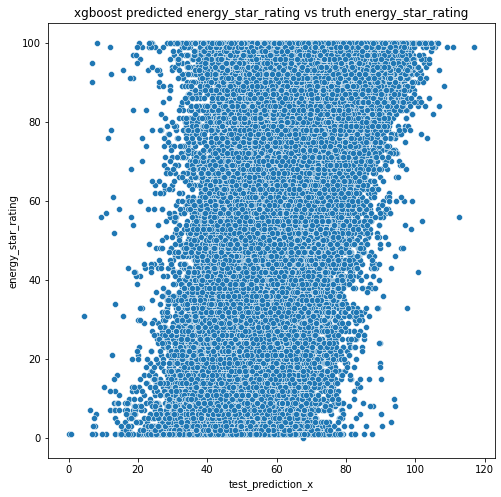

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=compare_predict_imputed_with_truth_result, x="test_prediction_x", y="energy_star_rating", ax = ax)
plt.title("xgboost predicted energy_star_rating vs truth energy_star_rating")
plt.show()

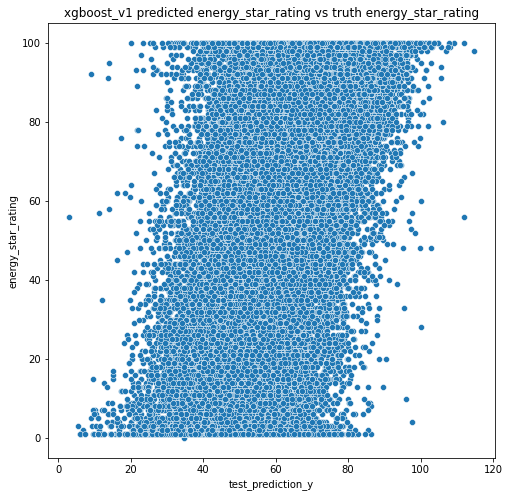

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=compare_predict_imputed_with_truth_result, x="test_prediction_y", y="energy_star_rating", ax = ax)
plt.title("xgboost_v1 predicted energy_star_rating vs truth energy_star_rating")
plt.show()

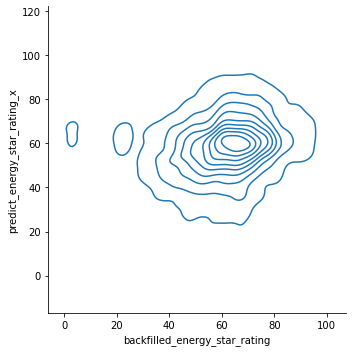

<IPython.core.display.Javascript object>

In [26]:
sns.displot(compare_imputed_result, x="backfilled_energy_star_rating", y="predict_energy_star_rating_x", kind="kde")

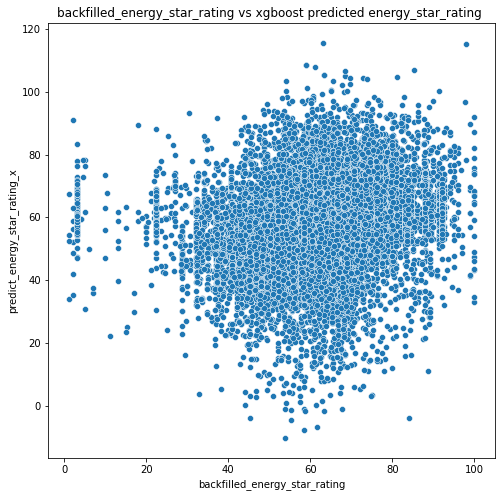

<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=compare_imputed_result, x="backfilled_energy_star_rating", y="predict_energy_star_rating_x", ax = ax)
plt.title("backfilled_energy_star_rating vs xgboost predicted energy_star_rating ")
plt.show()

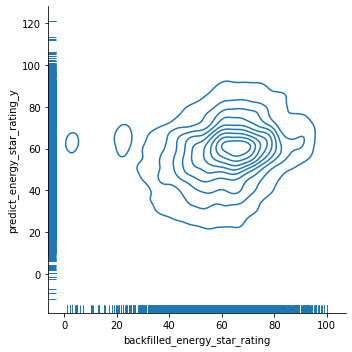

<IPython.core.display.Javascript object>

In [28]:
sns.displot(compare_imputed_result, x="backfilled_energy_star_rating", y="predict_energy_star_rating_y", kind="kde", rug=True)

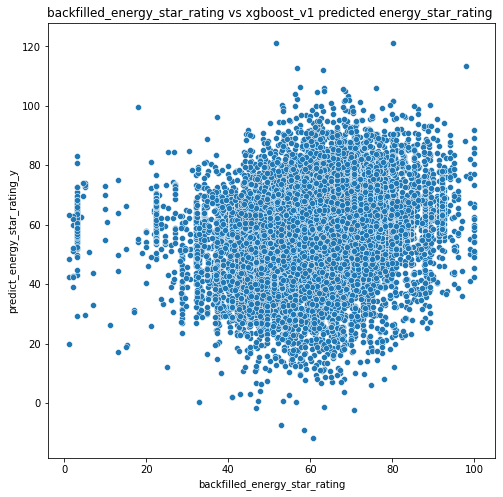

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=compare_imputed_result, x="backfilled_energy_star_rating", y="predict_energy_star_rating_y", ax = ax)
plt.title("backfilled_energy_star_rating vs xgboost_v1 predicted energy_star_rating ")
plt.show()